# 🛡️ Network Intrusion Detection - NSL-KDD
## Secure Cloud Computing - Step A: Training del Modello ML

Questo notebook addestra un modello di **classificazione multiclasse** per rilevare traffico di rete anomalo (Dos, Probe, R2L, U2R e normal).

**Dataset:** NSL-KDD  
**Modello:** Random Forest Classifier  
---
### Struttura del Notebook
1. Setup & Installazione dipendenze
2. Mount Google Drive
3. Download Dataset NSL-KDD
4. Esplorazione dei Dati (EDA)
5. Preprocessing
6. Training del Modello
7. Valutazione
8. Salvataggio Artefatti

## 1. 📦 Setup & Installazione Dipendenze

In [1]:
!pip install -q pandas scikit-learn xgboost joblib numpy matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score
)
from sklearn.model_selection import cross_val_score

print('✅ Librerie importate correttamente')

✅ Librerie importate correttamente


## 2. 💾 Mount Google Drive
Monteremo Google Drive per salvare il modello addestrato in modo persistente.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Cartella di output su Google Drive
OUTPUT_DIR = '/content/drive/MyDrive/network_intrusion/model_artifacts'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f'✅ Output directory: {OUTPUT_DIR}')

Mounted at /content/drive
✅ Output directory: /content/drive/MyDrive/network_intrusion/model_artifacts


## 3. 📥 Download Dataset NSL-KDD
Scarichiamo direttamente il dataset dal repository ufficiale di UNB.

In [4]:
# Download dataset NSL-KDD dal repository GitHub pubblico
!wget -q -O KDDTrain+.txt https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt
!wget -q -O KDDTest+.txt  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt

# Verifica download
train_size = os.path.getsize('KDDTrain+.txt') / 1024 / 1024
test_size  = os.path.getsize('KDDTest+.txt')  / 1024 / 1024
print(f'✅ KDDTrain+.txt scaricato: {train_size:.2f} MB')
print(f'✅ KDDTest+.txt  scaricato: {test_size:.2f} MB')

✅ KDDTrain+.txt scaricato: 18.22 MB
✅ KDDTest+.txt  scaricato: 3.28 MB


In [5]:
# Definizione colonne del dataset NSL-KDD
# Il dataset NSL-KDD è un file .txt senza intestazione, quindi dobbiamo dirgli manualmente come si chiamano le 43 colonne.
COLUMNS = [
    'duration', 'protocol_type', 'service', 'flag',
    'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
    'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count',
    'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'label', 'difficulty'
]

CATEGORICAL_COLS = ['protocol_type', 'service', 'flag']

# Mapping attacchi → categoria
# Nel dataset ci sono decine di label specifiche (neptune, smurf, nmap...). Questo dizionario le raggruppa in 5 macro-categorie:
# normal, DoS, Probe(scansioni), R2L(accesso remoto non autorizzato) e U2R(privilege escalation)
ATTACK_MAP = {
    'normal': 'normal',
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS',
    'smurf': 'DoS', 'teardrop': 'DoS', 'mailbomb': 'DoS',
    'apache2': 'DoS', 'processtable': 'DoS', 'udpstorm': 'DoS',
    'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe',
    'satan': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',
    'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L',
    'multihop': 'R2L', 'phf': 'R2L', 'spy': 'R2L',
    'warezclient': 'R2L', 'warezmaster': 'R2L', 'sendmail': 'R2L',
    'named': 'R2L', 'snmpgetattack': 'R2L', 'snmpguess': 'R2L',
    'xlock': 'R2L', 'xsnoop': 'R2L', 'httptunnel': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R',
    'rootkit': 'U2R', 'ps': 'U2R', 'sqlattack': 'U2R', 'xterm': 'U2R',
}

# Caricamento dataset
df_train = pd.read_csv('KDDTrain+.txt', header=None, names=COLUMNS)
df_test  = pd.read_csv('KDDTest+.txt',  header=None, names=COLUMNS)
# difficulty è un punteggio di difficoltà della classificazione incluso nel dataset
# inutile per il nostro modello, quindi la eliminiamo subito.
df_train.drop(columns=['difficulty'], inplace=True)
df_test.drop(columns=['difficulty'],  inplace=True)

print(f'Train set: {df_train.shape[0]:,} campioni, {df_train.shape[1]} colonne')
print(f'Test set:  {df_test.shape[0]:,} campioni, {df_test.shape[1]} colonne')
df_train.head()

Train set: 125,973 campioni, 42 colonne
Test set:  22,544 campioni, 42 colonne


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


## 4. 🔍 Esplorazione dei Dati (EDA)

> ### 📝 Nota - Distribuzione delle Label
>
> Il dataset è fortemente **sbilanciato**. Le classi dominanti sono `normal` (67k) e `neptune` (ovvero syn flooding, 41k) che da sole coprono la maggior parte dei campioni. Scendendo troviamo attacchi **Probe** (`satan`, `ipsweep`, `portsweep`, `nmap`) con qualche migliaio di esempi, mentre **R2L** (`warezclient`, `guess_passwd`, `warezmaster`) e **U2R** (`buffer_overflow`) sono quasi assenti con poche decine di campioni.
>
> Questo squilibrio è il principale limite del dataset: il modello imparerà bene a riconoscere DoS e traffico normale, ma potrebbe avere difficoltà con le classi rare. Per compensare, nel training usiamo `class_weight='balanced'`,  dando più peso alle classi rare durante il training.

In [6]:
# Distribuzione delle label nel training set
label_counts = df_train['label'].value_counts()
print('Top 15 label nel training set:')
print(label_counts.head(15))

Top 15 label nel training set:
label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
Name: count, dtype: int64


> ### 📝 Nota - EDA: Distribuzione Categorie
>
> La cella aggiunge la colonna `label_multi` mappando le label specifiche nelle 5 macro-categorie tramite `ATTACK_MAP` (`.fillna('other')` gestisce attacchi non mappati). Produce poi due grafici:
>
> - **Barre (sx)**: distribuzione dei campioni per macro-categoria — conferma lo squilibrio, con `normal` e `DoS` dominanti rispetto a `R2L` e `U2R` quasi invisibili.
> - **Torta (dx)**: visione binaria Normal vs Attack in percentuale — utile per capire il rapporto generale tra traffico legittimo e malevolo nel training set.
>
> Entrambi i grafici vengono salvati su Google Drive in `eda_distribution.png` per la relazione.

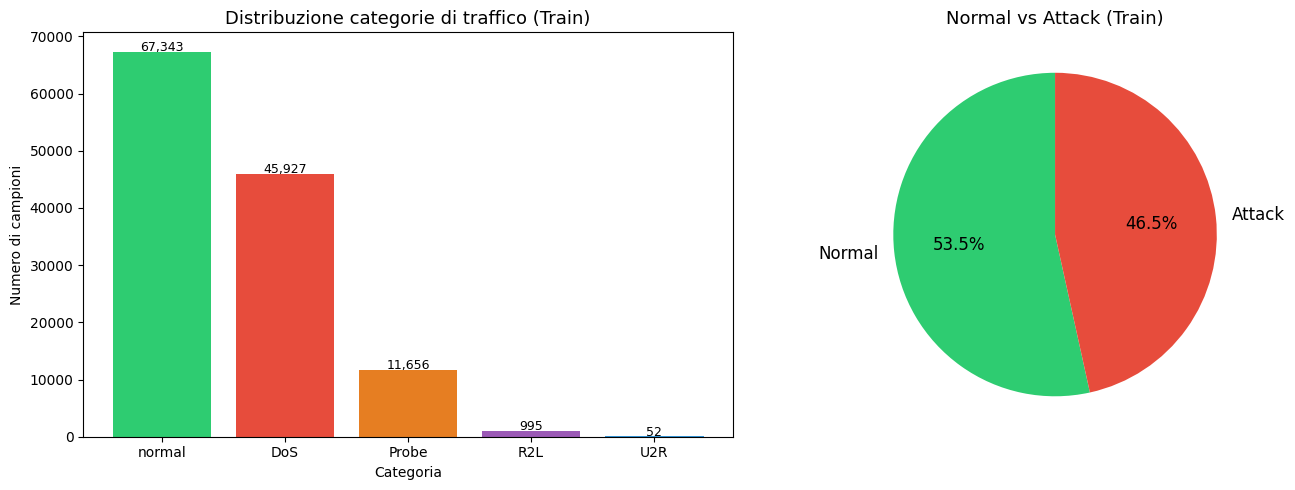

✅ Grafico EDA salvato


In [7]:
# Aggiungiamo le label multiclasse per l'EDA
df_train['label_multi'] = df_train['label'].map(ATTACK_MAP).fillna('other')
df_test['label_multi']  = df_test['label'].map(ATTACK_MAP).fillna('other')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grafico 1: distribuzione categorie attacco
cat_counts = df_train['label_multi'].value_counts()
axes[0].bar(cat_counts.index, cat_counts.values,
            color=['#2ecc71', '#e74c3c', '#e67e22', '#9b59b6', '#3498db'])
axes[0].set_title('Distribuzione categorie di traffico (Train)', fontsize=13)
axes[0].set_xlabel('Categoria')
axes[0].set_ylabel('Numero di campioni')
for i, v in enumerate(cat_counts.values):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', fontsize=9)

# Grafico 2: binary (normal vs attack)
binary_counts = df_train['label'].apply(lambda x: 'Normal' if x == 'normal' else 'Attack').value_counts()
axes[1].pie(binary_counts.values, labels=binary_counts.index,
            autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'],
            startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Normal vs Attack (Train)', fontsize=13)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'eda_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()
print('✅ Grafico EDA salvato')

> ### 📝 Nota - EDA: Distribuzione Colonne Categoriche
>
> La cella produce 3 grafici a barre orizzontali, uno per ognuna delle colonne categoriche (`protocol_type`, `service`, `flag`), mostrando i 10 valori più frequenti.
>
> - **protocol_type**: protocolli di rete usati (`tcp`, `udp`, `icmp`) — solo 3 valori possibili
> - **service**: servizio di destinazione della connessione (`http`, `ftp`, `ssh`, ecc.) — molti valori, per questo si mostrano solo i top 10
> - **flag**: stato della connessione TCP (`SF` = connessione normale completata, `S0` = SYN senza risposta tipico di attacchi, `REJ` = connessione rifiutata, ecc.)
>
> Queste 3 colonne sono le uniche categoriche del dataset e nella fase di preprocessing verranno trasformate in numeri tramite `LabelEncoder`.

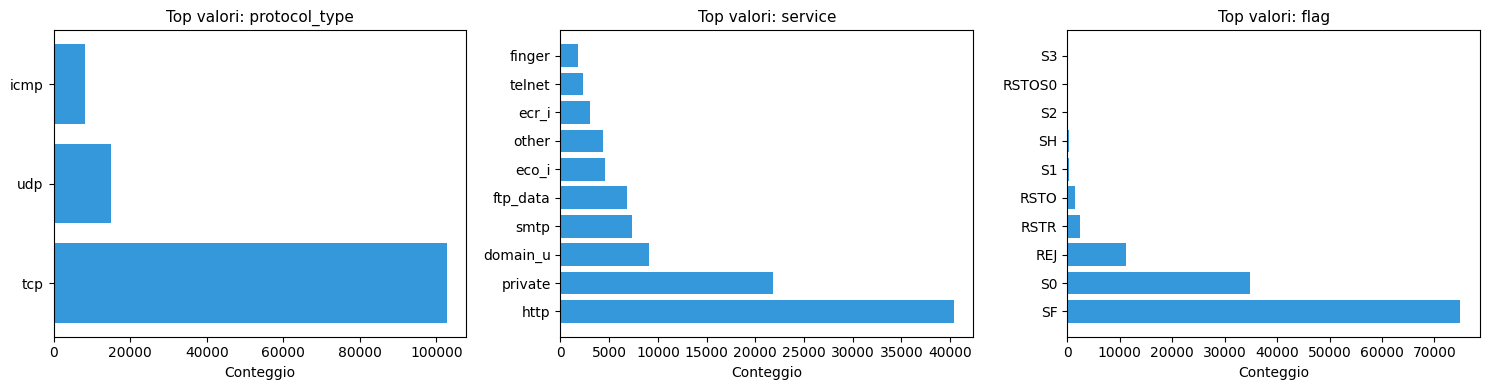

In [8]:
# Distribuzione protocolli
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, col in zip(axes, CATEGORICAL_COLS):
    counts = df_train[col].value_counts().head(10)
    ax.barh(counts.index, counts.values, color='#3498db')
    ax.set_title(f'Top valori: {col}', fontsize=11)
    ax.set_xlabel('Conteggio')

plt.tight_layout()
plt.show()

> ### 📝 Nota - EDA: Statistiche Descrittive
>
> `.describe()` mostra 8 statistiche per ogni colonna numerica: `count`, `mean`, `std`, `min`, `25%`, `50%` (mediana), `75%`, `max`.
>
> Valori a cui prestare attenzione:
> - **max molto alto rispetto alla media** (es. `src_bytes`) → presenza di outlier
> - **std = 0** → la colonna ha sempre lo stesso valore e non porta informazione al modello
> - **count inferiore al totale** → valori mancanti da gestire
>
> Queste osservazioni giustificano l'uso dello `StandardScaler` nel preprocessing, che riporta tutte le feature sulla stessa scala evitando che colonne con valori molto grandi dominino il modello.

In [9]:
# Statistiche generali
print('Statistiche dataset di training:')
df_train.describe().round(2)

Statistiche dataset di training:


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00,1.259730e+05,1.259730e+05,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,...,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00
mean,287.14,4.556674e+04,1.977911e+04,0.00,0.02,0.00,0.20,0.00,0.40,0.28,...,182.15,115.65,0.52,0.08,0.15,0.03,0.28,0.28,0.12,0.12
std,2604.52,5.870331e+06,4.021269e+06,0.01,0.25,0.01,2.15,0.05,0.49,23.94,...,99.21,110.70,0.45,0.19,0.31,0.11,0.44,0.45,0.31,0.32
min,0.00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,82.00,10.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,4.400000e+01,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,255.00,63.00,0.51,0.02,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,2.760000e+02,5.160000e+02,0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,255.00,255.00,1.00,0.07,0.06,0.02,1.00,1.00,0.00,0.00
max,42908.00,1.379964e+09,1.309937e+09,1.00,3.00,3.00,77.00,5.00,1.00,7479.00,...,255.00,255.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## 5. ⚙️ Preprocessing

In [10]:
df_train['label_multi'] = df_train['label'].map(ATTACK_MAP).fillna('other')
df_test['label_multi']  = df_test['label'].map(ATTACK_MAP).fillna('other')

print('Distribuzione label multiclasse (Train):')
print(df_train['label_multi'].value_counts())
print()
print('Distribuzione label multiclasse (Test):')
print(df_test['label_multi'].value_counts())

Distribuzione label multiclasse (Train):
label_multi
normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64

Distribuzione label multiclasse (Test):
label_multi
normal    9711
DoS       7458
R2L       2885
Probe     2421
U2R         67
other        2
Name: count, dtype: int64


> ### 📝 Nota — Label Encoding delle Colonne Categoriche
>
> Il dataset NSL-KDD contiene 3 colonne testuali (`protocol_type`, `service`, `flag`) che il Random Forest non può elaborare direttamente. Questa cella le converte in interi tramite `LabelEncoder`.
>
> **Perché fittiamo su train + test combinati?**
> Se fittassimo il `LabelEncoder` solo sul training set, un valore presente solo nel test set (es. un servizio raro) causerebbe un errore a runtime. Concatenando i due set prima del fit, garantiamo che tutti i valori possibili abbiano un encoding numerico stabile.
>
> **Cosa viene salvato in `encoders`?**
> Un dizionario `{colonna → LabelEncoder}` serializzato in `encoders.pkl`. Sarà ricaricato nella Web App (Step B) per trasformare allo stesso modo i dati in ingresso, assicurando coerenza tra training e serving.

In [11]:
# ── Label Encoding per colonne categoriche ──
encoders = {}
for col in CATEGORICAL_COLS:
    le = LabelEncoder()
    combined = pd.concat([df_train[col], df_test[col]], axis=0)
    le.fit(combined)
    df_train[col] = le.transform(df_train[col])
    df_test[col]  = le.transform(df_test[col])
    encoders[col] = le
    print(f'  {col}: {list(le.classes_)}')

print('\n✅ Encoding completato')

  protocol_type: ['icmp', 'tcp', 'udp']
  service: ['IRC', 'X11', 'Z39_50', 'aol', 'auth', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp', 'ftp_data', 'gopher', 'harvest', 'hostnames', 'http', 'http_2784', 'http_443', 'http_8001', 'imap4', 'iso_tsap', 'klogin', 'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns', 'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u', 'other', 'pm_dump', 'pop_2', 'pop_3', 'printer', 'private', 'red_i', 'remote_job', 'rje', 'shell', 'smtp', 'sql_net', 'ssh', 'sunrpc', 'supdup', 'systat', 'telnet', 'tftp_u', 'tim_i', 'time', 'urh_i', 'urp_i', 'uucp', 'uucp_path', 'vmnet', 'whois']
  flag: ['OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH']

✅ Encoding completato


In [12]:
# ── Separazione Features e Target ──
FEATURE_COLS = [c for c in df_train.columns
                if c not in ['label', 'label_multi']]

X_train = df_train[FEATURE_COLS]
y_train = df_train['label_multi']
X_test  = df_test[FEATURE_COLS]
y_test  = df_test['label_multi']

print(f'Features utilizzate: {len(FEATURE_COLS)}')
print(f'X_train shape: {X_train.shape}')
print(f'X_test  shape: {X_test.shape}')

Features utilizzate: 41
X_train shape: (125973, 41)
X_test  shape: (22544, 41)


In [13]:
# ── Scaling ──
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print('✅ Scaling completato')
print(f'   Media features (dovrebbe essere ~0): {X_train_scaled.mean():.4f}')
print(f'   Std features   (dovrebbe essere ~1): {X_train_scaled.std():.4f}')

✅ Scaling completato
   Media features (dovrebbe essere ~0): -0.0000
   Std features   (dovrebbe essere ~1): 0.9877


## 6. 🤖 Training del Modello

In [17]:
%%time
# ── Training Random Forest ──
# n_estimators=100: 100 alberi decisionali
# max_depth=20: profondità massima di ogni albero
# class_weight='balanced': gestisce lo sbilanciamento tra classi
# n_jobs=-1: usa tutti i core disponibili su Colab

# Pesi manuali per forzare attenzione su R2L e U2R
custom_weights = {
    'normal': 1,
    'DoS':    1,
    'Probe':  2,
    'R2L':    20,   # ← fortemente sottorappresentata
    'U2R':    50,   # ← quasi assente
    'other':  1
}

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42,
    class_weight=custom_weights
)

model.fit(X_train_scaled, y_train)
print('✅ Training completato!')

✅ Training completato!
CPU times: user 18.3 s, sys: 64.2 ms, total: 18.3 s
Wall time: 17.5 s


## 7. 📊 Valutazione del Modello

In [18]:
y_pred = model.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, average='weighted')

print('=' * 50)
print(f'  Accuracy  : {acc:.4f}  ({acc*100:.2f}%)')
print(f'  F1 Score  : {f1:.4f}')
print('=' * 50)
print()

# Ricava le classi nell'ordine in cui sklearn le vede
classes = sorted(y_test.unique())
print(f'Classi rilevate: {classes}')
print()
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=classes))

  Accuracy  : 0.7458  (74.58%)
  F1 Score  : 0.6993

Classi rilevate: ['DoS', 'Probe', 'R2L', 'U2R', 'normal', 'other']

Classification Report:
              precision    recall  f1-score   support

         DoS       0.96      0.77      0.86      7458
       Probe       0.88      0.65      0.75      2421
         R2L       0.89      0.01      0.02      2885
         U2R       0.62      0.07      0.13        67
      normal       0.64      0.97      0.77      9711
       other       0.00      0.00      0.00         2

    accuracy                           0.75     22544
   macro avg       0.67      0.41      0.42     22544
weighted avg       0.80      0.75      0.70     22544



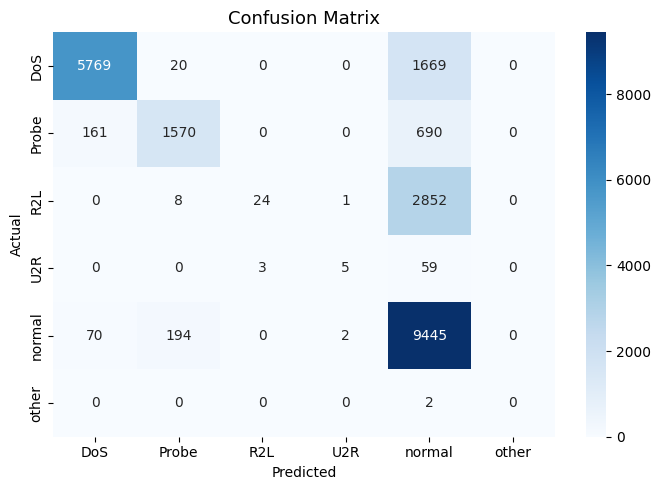

✅ Grafici salvati


In [20]:
# ── Confusion Matrix ──
fig, ax = plt.subplots(figsize=(7, 5))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=classes,
            yticklabels=classes)
ax.set_title('Confusion Matrix', fontsize=13)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()
print('✅ Grafici salvati')

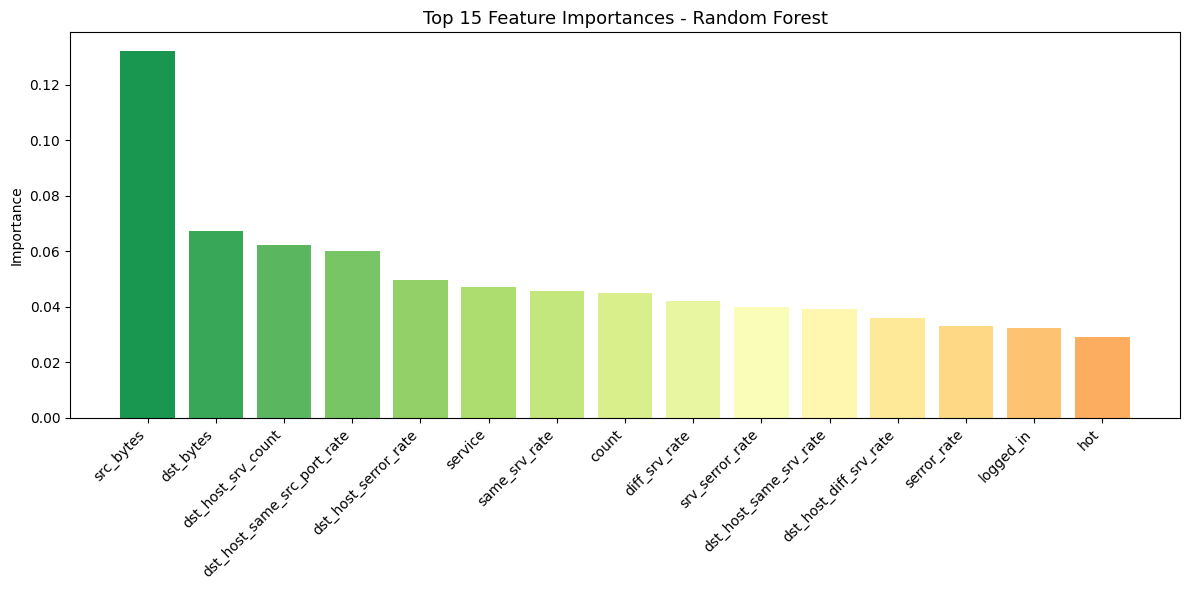

✅ Feature importance salvata


In [21]:
# ── Feature Importance ──
importances = model.feature_importances_
top_n = 15
indices = np.argsort(importances)[::-1][:top_n]

plt.figure(figsize=(12, 6))
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, top_n))[::-1]
bars = plt.bar(range(top_n), importances[indices], color=colors)
plt.xticks(range(top_n),
           [FEATURE_COLS[i] for i in indices],
           rotation=45, ha='right', fontsize=10)
plt.title(f'Top {top_n} Feature Importances - Random Forest', fontsize=13)
plt.ylabel('Importance')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importance.png'), dpi=150, bbox_inches='tight')
plt.show()
print('✅ Feature importance salvata')

In [22]:
print('Accuracy per categoria di attacco:')
results = []
for cat in df_test['label_multi'].unique():
    mask = df_test['label_multi'] == cat
    if mask.sum() == 0:
        continue
    cat_acc = accuracy_score(y_test[mask], y_pred[mask])
    results.append({'Categoria': cat, 'Campioni': int(mask.sum()), 'Accuracy': f'{cat_acc:.4f}'})

results_df = pd.DataFrame(results).sort_values('Campioni', ascending=False)
print(results_df.to_string(index=False))

Accuracy per categoria di attacco:
Categoria  Campioni Accuracy
   normal      9711   0.9726
      DoS      7458   0.7735
      R2L      2885   0.0083
    Probe      2421   0.6485
      U2R        67   0.0746
    other         2   0.0000


## 8. 💾 Salvataggio Artefatti
Salviamo tutto su Google Drive per usarlo nello Step B (Web App).

In [24]:
# Salvataggio modello e artefatti
joblib.dump(model,        os.path.join(OUTPUT_DIR, 'model.pkl'))
joblib.dump(scaler,       os.path.join(OUTPUT_DIR, 'scaler.pkl'))
joblib.dump(encoders,     os.path.join(OUTPUT_DIR, 'encoders.pkl'))
joblib.dump(FEATURE_COLS, os.path.join(OUTPUT_DIR, 'feature_names.pkl'))

# Salviamo anche le metriche in un file di testo
with open(os.path.join(OUTPUT_DIR, 'metrics.txt'), 'w') as f:
    f.write('=== Network Intrusion Detection - Model Metrics ===\n\n')
    f.write(f'Accuracy  : {acc:.4f}\n')
    f.write(f'F1 Score  : {f1:.4f}\n')
    f.write(classification_report(y_test, y_pred, target_names=classes))

print('✅ Artefatti salvati in Google Drive:')
for f in os.listdir(OUTPUT_DIR):
    size = os.path.getsize(os.path.join(OUTPUT_DIR, f)) / 1024
    print(f'   {f:35s} {size:8.1f} KB')

✅ Artefatti salvati in Google Drive:
   eda_distribution.png                    75.6 KB
   confusion_matrix.png                    53.8 KB
   feature_importance.png                  98.2 KB
   model.pkl                             9565.4 KB
   scaler.pkl                               2.5 KB
   encoders.pkl                             1.6 KB
   feature_names.pkl                        0.7 KB
   metrics.txt                              0.6 KB


## ✅ Riepilogo Finale

In [25]:
print('=' * 55)
print('   STEP A COMPLETATO - Network Intrusion Detection')
print('=' * 55)
print(f'  Modello:    Random Forest (100 alberi, depth=20)')
print(f'  Dataset:    NSL-KDD')
print(f'  Train set:  {len(X_train):,} campioni')
print(f'  Test set:   {len(X_test):,} campioni')
print(f'  Features:   {len(FEATURE_COLS)}')
print(f'  Accuracy:   {acc*100:.2f}%')
print(f'  F1 Score:   {f1:.4f}')
print('=' * 55)
print()
print('  Artefatti salvati:')
print(f'  📁 {OUTPUT_DIR}')
print('     ├── model.pkl          ← Modello addestrato')
print('     ├── scaler.pkl         ← StandardScaler')
print('     ├── encoders.pkl       ← LabelEncoders')
print('     ├── feature_names.pkl  ← Lista features')
print('     ├── metrics.txt        ← Metriche')
print('     ├── confusion_matrix_roc.png')
print('     ├── feature_importance.png')
print('     └── eda_distribution.png')
print()

   STEP A COMPLETATO - Network Intrusion Detection
  Modello:    Random Forest (100 alberi, depth=20)
  Dataset:    NSL-KDD
  Train set:  125,973 campioni
  Test set:   22,544 campioni
  Features:   41
  Accuracy:   74.58%
  F1 Score:   0.6993

  Artefatti salvati:
  📁 /content/drive/MyDrive/network_intrusion/model_artifacts
     ├── model.pkl          ← Modello addestrato
     ├── scaler.pkl         ← StandardScaler
     ├── encoders.pkl       ← LabelEncoders
     ├── feature_names.pkl  ← Lista features
     ├── metrics.txt        ← Metriche
     ├── confusion_matrix_roc.png
     ├── feature_importance.png
     └── eda_distribution.png

